<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/01.01-Rosetta-Stone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A kind of Rosetta stone to help you translate R to Python

The goal of this notebook is to show how a R code could be translated into a Python code. If you don't know the Rosetta stone, take a look [here](https://en.wikipedia.org/wiki/Rosetta_Stone).

As an example, we will take a group assignment of the Modelagem e Simulação course taught by Prof. Alexandre Tôrres, kindly shared by your classmate Arthur Cangussu.

The next cell contains part of the original R code and should not be executed, since this is a Python notebook. In order to execute R code we need to use a R  kernel. Take a look [here](https://jupyter-client.readthedocs.io/en/latest/kernels.html) to understand what a kernel is.

In [ ]:
rm(list = ls(all.names = TRUE))

#TG Modelagem e Simulaзгo - Arthur, Camilla, Daniele, Isabella, Yuri

#Tanque cilнndrico bifбsico deitado com controle de nнvel PD.
#Sistema possui 2 correntes: Entrada (q_f) e saнda (q_l)
#Corrente lнquida de saнda manipulada pelo controle
#Perturbaзгo tipo degrau para avaliar comportamento do sistema

# v -> N2
# l -> H2O

###### Dados de Projeto ####
hT <- 3 #m
Lc <- 10 #m
VT <- (pi*((hT^2)/4))*Lc


#### Dados do processo ####
h_l0 <- 0.01
Pi <- 1 #atm

## correntes ##
x_v_f <- 0.05
x_l_f <- 1 - x_v_f
q_f <- 10 #L/s
q_l <- 4 #L/s
q_f_m <- q_f/1e3 
q_l_m <- q_l/1e3
q_l_m0 <- q_l_m

##### Dados de Componentes ####
rho_v <- 1.185 #Kg/m3 (15c e 1 atm)
rho_l <- 997 #Kg/m3
Mv <- 28.0134*1000 #Kg/mol
Ml <- 18.01528*1000 #Kg/mol
Mf <- Mv*x_v_f + Ml*x_l_f #g/mol
T <- 25+273.15 #K
R <- 8.20574587e-5 #m3*atm*K???1*mol???1

#### Controlador ####
h_l_sp <- 1.5 #m
k_cp <- 0.01  #0.01
k_cd <- 20    #20

#### Pacotes necessбrios ####
require(deSolve)

##### Funзгo da бrea seccionada ####
f_area_hl <- function(hl){
  area_hl <- (((hT^2)/4)*(cos(asin(((2*hl)/hT)-1))*(((2*hl)/hT)-1)+asin(((2*hl)/hT)-1)))+
             ((pi*(hT^2))/8)
  return(area_hl)
}

#### Derivada da funзгo da бrea seccionada ####
f_d_area_hl <- function(dhl,hl){
  d_area_hl <- dhl*(((hT*((1-((((2*hl)/hT)-1)^2))^(1/2)))/2)- 
                   ((hT*((((2*hl)/hT)-1)^2))/(2*(1-((((2*hl)/hT)-1)^2))^(1/2)))+
                   ((hT)/(2*(1-((((2*hl)/hT)-1)^2))^(1/2))))
  return(d_area_hl)
}

#### Soluзгo em h - real  e diferencial ####
y_der_h <- function(t,y,param){
  dy <- numeric(length = length(y))
  #
  #Equivalкncia variбveis
  #
  h_l   <- y[1]
  P     <- y[2]
  q_l_m <- y[3]
  #
  #Parвmetros
  #
  q_f_m  <- param[1]
  x_l_f  <- param[2]
  x_v_f  <- param[3]
  hT     <- param[4]
  Lc     <- param[5]
  rho_l  <- param[6]
  R      <- param[7]
  T      <- param[8]
  Mv     <- param[9]
  VT     <- param[10]
  k_cp   <- param[11]
  k_cd   <- param[12]
  h_l_sp <- param[13]
  #
    dy[1] <- (((x_l_f*q_f_m)-q_l_m)*(2/hT)*(1/Lc))/(((1-((((2*h_l)/hT)-1)^2))^(1/2))-((((2*h_l)/hT)-1)^2)/((1-((((2*h_l)/hT)-1)^2))^(1/2))+(1/((1-((((2*h_l)/hT)-1)^2))^(1/2))))
    dy[2] <- (((x_v_f*rho_l*q_f_m*R*T)/Mv)+(f_d_area_hl(dy[1],h_l)*Lc*P))*(1/(VT-(f_area_hl(h_l)*Lc)))
    dy[3] <- - k_cp*((h_l_sp - h_l) + (-dy[1]*k_cd))
  saida <- list(dy)
  return(saida)
}

param <- numeric(20)
param[1]  <- q_f_m  
param[2]  <- x_l_f  
param[3]  <- x_v_f  
param[4]  <- hT     
param[5]  <- Lc     
param[6]  <- rho_l 
param[7]  <- R      
param[8]  <- T      
param[9]  <- Mv     
param[10] <- VT     
param[11] <- k_cp
param[12] <- k_cd
param[13] <- h_l_sp

y_ini <- c(h_l0,Pi,q_l_m0)

dhfhT_0 <- y_der_h(0,y_ini,param)
dhfhT_0

y <- y_ini
t_op <- 3 #h
t_sim <- t_op*3600   # s

sol_h_real <- ode(y = y_ini, func = y_der_h, 
             times = 0:t_sim,parms = param)

colnames(sol_h_real) <- c("tempo","h_l","P","q_l")
head(sol_h_real)

tail(sol_h_real)

sol_h_real <- data.frame(sol_h_real)

#Construзгo dos grбficos

par(mar=c(4,4,1,1))

plot(sol_h_real$tempo, sol_h_real$h_l,type="l",xlab = "tempo(s)",ylab = "hl (m)",main="Controle de Nнvel",col='blue',xlim = c(0,t_sim),ylim=c(0,hT))
grid(col = "gray")
abline(h=h_l_sp,  lty = 3, col = "orange", lwd = 1)

plot(sol_h_real$tempo, sol_h_real$P,type="l",xlab = "tempo(s)",ylab = "P(atm)",main="Controle de Pressгo",col='red',xlim = c(0,t_sim),ylim=c(Pi,10))
grid(col = "gray")

#### Perturbaзгo tipo degrau em uma vazгo de entrada ####
f_vaz_pert_degrau <- function(t, vaz_ent, t_eve, f_degrau) {
  
  if(t < t_eve){
    vaz <- vaz_ent
  }else{
    vaz <- vaz_ent * f_degrau
  }
  return(vaz)
}

np <- 1000
t_gr <- seq(1,t_sim, length.out = np)
vaz_gr <- numeric(np)
t_eve <- 4000
f_degrau <- 10
for (i in 1:np) {
  vaz_gr[i] <- f_vaz_pert_degrau(t = t_gr[i], q_f_m, t_eve, f_degrau)
}

par(mar=c(4,4,1,1))
plot(x = t_gr, y = vaz_gr, type = "l",
     pch = ".", xlab = "tempo / s",
     ylab = "vazГЈo, m3/s", col = "red",
     xlim = c(0,t_sim), ylim = c(0,1))
grid(col = "gray")
abline(v = t_eve, col = "pink", lwd = 3, lty = 2)

The corresponding Python code of this first part is given in the next cell, which could be executed.

[0.0015903660629071603, 5.559553878356587e-08, -0.014899988880892244]
       tempo       h_l         P       q_l
0   0.000000  0.010000  1.000000  0.004000
1   3.000834  0.027750  1.000000 -0.040498
2   6.001667  0.058166  1.000000 -0.084241
3   9.002501  0.094806  1.000001 -0.126970
4  12.003334  0.135797  1.000001 -0.168532
          tempo       h_l         P       q_l
100  300.083356  0.249412  0.999997  0.310966
101  303.084190  0.195458  0.999997  0.272625
102  306.085024  0.142305  0.999998  0.232680
103  309.085857  0.090412  0.999998  0.191167
104  312.086691  0.033054  0.999998  0.148026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in arcsin


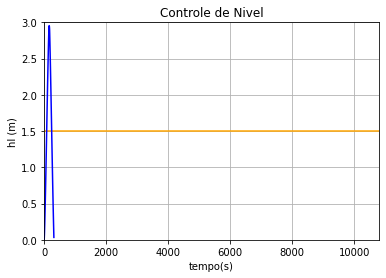

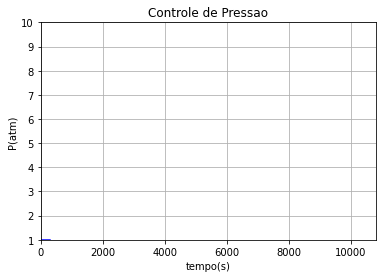

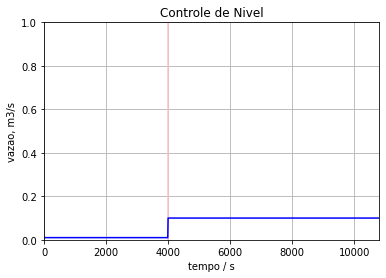

In [4]:
#TG Modelagem e Simulacao - Arthur, Camilla, Daniele, Isabella, Yuri

#Tanque cilindrico bifasico horizontal com controle de nivel PD.
#Sistema possui 2 correntes: Entrada (q_f) e saida (q_l)
#Corrente liquida de saida manipulada pelo controle
#Perturbacao tipo degrau para avaliar comportamento do sistema

# v -> N2
# l -> H2O

#### Pacotes necessarios ####
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
%matplotlib inline
import matplotlib.pyplot as plt

###### Dados de Projeto ####
hT = 3 #m
Lc = 10 #m
VT = (np.pi*((hT^2)/4))*Lc


#### Dados do processo ####
h_l0 = 0.01
Pi = 1 #atm

## correntes ##
x_v_f = 0.05
x_l_f = 1 - x_v_f
q_f = 10 #L/s
q_l = 4 #L/s
q_f_m = q_f/1e3 
q_l_m = q_l/1e3
q_l_m0 = q_l_m

##### Dados de Componentes ####
rho_v = 1.185 #Kg/m3 (15c e 1 atm)
rho_l = 997 #Kg/m3
Mv = 28.0134*1000 #Kg/mol
Ml = 18.01528*1000 #Kg/mol
Mf = Mv*x_v_f + Ml*x_l_f #g/mol
T = 25+273.15 #K
R = 8.20574587e-5 #m3*atm*K???1*mol???1

#### Controlador ####
h_l_sp = 1.5 #m
k_cp = 0.01  #0.01
k_cd = 20    #20

##### Funcao da area seccionada ####
def f_area_hl(hl):
  area_hl = (((hT**2)/4)*(np.cos(np.arcsin(((2*hl)/hT)-1))*(((2*hl)/hT)-1)+np.arcsin(((2*hl)/hT)-1)))+((np.pi*(hT**2))/8)
  return area_hl

#### Derivada da funcao da area seccionada ####
def f_d_area_hl(dhl, hl):
  d_area_hl = dhl*(((hT*((1-((((2*hl)/hT)-1)**2))**(1/2)))/2)- 
                   ((hT*((((2*hl)/hT)-1)**2))/(2*(1-((((2*hl)/hT)-1)**2))**(1/2)))+
                   ((hT)/(2*(1-((((2*hl)/hT)-1)**2))**(1/2))))
  return d_area_hl

#### Solucao em h - real  e diferencial ####
def y_der_h(t, y, *param):
  dy = len(y)*[0]
  #
  #Equivalencia variaveis
  #
  h_l   = y[0]
  P     = y[1]
  q_l_m = y[2]
  #
  #Parametros
  #
  q_f_m  = param[0][0]
  x_l_f  = param[0][1]
  x_v_f  = param[0][2]
  hT     = param[0][3]
  Lc     = param[0][4]
  rho_l  = param[0][5]
  R      = param[0][6]
  T      = param[0][7]
  Mv     = param[0][8]
  VT     = param[0][9]
  k_cp   = param[0][10]
  k_cd   = param[0][11]
  h_l_sp = param[0][12]
  #
  dy[0] = (((x_l_f*q_f_m)-q_l_m)*(2/hT)*(1/Lc))/(((1-((((2*h_l)/hT)-1)**2))**(1/2))-((((2*h_l)/hT)-1)**2)/((1-((((2*h_l)/hT)-1)**2))**(1/2))+(1/((1-((((2*h_l)/hT)-1)**2))**(1/2))))
  dy[1] = (((x_v_f*rho_l*q_f_m*R*T)/Mv)+(f_d_area_hl(dy[1],h_l)*Lc*P))*(1/(VT-(f_area_hl(h_l)*Lc)))
  dy[2] = - k_cp*((h_l_sp - h_l) + (-dy[1]*k_cd))
  return dy

param = 13*[0]
param[0]  = q_f_m  
param[1]  = x_l_f  
param[2]  = x_v_f  
param[3]  = hT     
param[4]  = Lc     
param[5]  = rho_l 
param[6]  = R      
param[7]  = T      
param[8]  = Mv     
param[9] = VT     
param[10] = k_cp
param[11] = k_cd
param[12] = h_l_sp

y_ini = [h_l0, Pi, q_l_m0]

dhfhT_0 = y_der_h(0,y_ini,param)
print(dhfhT_0)

y = y_ini
t_op = 3 #h
t_sim = t_op*3600   # s

times = np.linspace(0, t_sim, num=3600)  
sol_h_real = solve_ivp(y_der_h, (times[0], times[-1]), y_ini, t_eval=times, args=(param,))

sol_h_real = pd.DataFrame(data={'tempo':sol_h_real.t, 
                                'h_l'  :sol_h_real.y[0], 
                                'P'    :sol_h_real.y[1], 
                                'q_l'  :sol_h_real.y[2]})
print(sol_h_real.head())
print(sol_h_real.tail())

#Construcao dos graficos

plt.plot(sol_h_real['tempo'], sol_h_real['h_l'], 'b')
plt.xlabel('tempo(s)');
plt.ylabel('hl (m)');
plt.title('Controle de Nivel')
plt.xlim([0, t_sim])
plt.ylim([0, hT])
plt.grid()
plt.hlines(h_l_sp, 0, t_sim, colors='orange')
plt.show()

plt.plot(sol_h_real['tempo'], sol_h_real['P'], 'b')
plt.xlabel('tempo(s)');
plt.ylabel('P(atm)');
plt.title('Controle de Pressao')
plt.xlim([0, t_sim])
plt.ylim([Pi, 10])
plt.grid()
plt.show()

#### Perturbacao tipo degrau em uma vazao de entrada ####
def f_vaz_pert_degrau(t, vaz_ent, t_eve, f_degrau):
  
  if t < t_eve:
    vaz = vaz_ent
  else:
    vaz = vaz_ent * f_degrau

  return vaz

npts = 1000
t_grs = np.linspace(1, t_sim, num=npts)
vaz_gr = npts*[0]
t_eve = 4000
f_degrau = 10
for i, t_gr in enumerate(t_grs):
  vaz_gr[i] = f_vaz_pert_degrau(t_gr, q_f_m, t_eve, f_degrau)

plt.plot(t_grs, vaz_gr, 'b')
plt.xlabel('tempo / s');
plt.ylabel('vazao, m3/s');
plt.title('Controle de Nivel')
plt.xlim([0, t_sim])
plt.ylim([0, 1])
plt.grid()
plt.vlines(t_eve, 0, 1, colors='pink')
plt.show()

Did you get the knack? If you did, then solve the following review problems.

(1) Did the Python code of the last cell reproduce the first part of the R code flawless? If it didn't, find and correct the error(s) in order to make the cell runs flawless and to reproduce the the R code exactly.

(2) Translate the code given in the next cell, which contains the second part of the original R code and should not be executed, since this is a Python notebook. The translation needs to run flawless and to reproduce the R code exactly.

In [ ]:
#### Modelo com a perturbaзгo degrau ####
y_der_h1 <- function(t,y,param){
  dy <- numeric(length = length(y))
  #
  #Equivalкncia variбveis
  #
  h_l   <- y[1]
  P     <- y[2]
  q_l_m <- y[3]
  #
  #Parвmetros
  #
  q_f_m  <- f_vaz_pert_degrau(t = t, param[1], t_eve, f_degrau)
  x_l_f  <- param[2]
  x_v_f  <- param[3]
  hT     <- param[4]
  Lc     <- param[5]
  rho_l  <- param[6]
  R      <- param[7]
  T      <- param[8]
  Mv     <- param[9]
  VT     <- param[10]
  k_cp   <- param[11]
  k_cd   <- param[12]
  h_l_sp <- param[13]
  #
  dy[1] <- (((x_l_f*q_f_m)-q_l_m)*(2/hT)*(1/Lc))/(((1-((((2*h_l)/hT)-1)ˆ2))ˆ(1/2))-((((2*h_l)/hT)-1)ˆ2)/((1-((((2*h_l)/hT)-1)ˆ2))ˆ(1/2))+(1/((1-((((2*h_l)/hT)-1)ˆ2))ˆ(1/2))))
  dy[2] <- (((x_v_f*rho_l*q_f_m*R*T)/Mv)+(f_d_area_hl(dy[1],h_l)*Lc*P))*(1/(VT-(f_area_hl(h_l)*Lc)))
  dy[3] <- - k_cp*((h_l_sp - h_l) + (-dy[1]*k_cd))
  saida <- list(dy)
  return(saida)
}

y_ini <- c(h_l0,Pi,q_l_m0)

dhfhT_01 <- y_der_h1(0,y_ini,param)
dhfhT_01

y <- y_ini
t_op <- 3 #h
t_sim <- t_op*3600 # s

sol_h_real1 <- ode(y = y_ini, func = y_der_h1, 
                     times = 0:t_sim, parms = param)

colnames(sol_h_real1) <- c("tempo","h_l","P","q_l")
head(sol_h_real1)
tail(sol_h_real1)

sol_h_real1 <- data.frame(sol_h_real1)
sol_h_real1$q_l <- (sol_h_real1$q_l)*1e3
#### Construзгo dos grбficos com pertubaзгo degrau ####

par(mar=c(4,4,1,1))

plot(sol_h_real1$tempo, sol_h_real1$h_l,type="l",xlab = "tempo(s)",ylab = "hl (m)",main="Controle de Nнvel Com Pertubaзгo",col='blue',xlim = c(0,t_sim),ylim=c(0,hT))
grid(col = "gray")
abline(h=h_l_sp,  lty = 3, col = "orange", lwd = 1)
abline(v = t_eve, col = "pink", lwd = 3, lty = 2)

plot(sol_h_real1$tempo, sol_h_real1$P,type="l",xlab = "tempo(s)",ylab = "P(atm)",main="Controle de Pressгo Com Pertubaзгo",col='red',xlim = c(0,t_sim),ylim=c(Pi,6))
grid(col = "gray")
abline(v = t_eve, col = "pink", lwd = 3, lty = 2)

plot(sol_h_real1$tempo, sol_h_real1$q_l,type="l",xlab = "tempo(s)",ylab = "q_l(L/s)",main="Controle de Pressгo Com Pertubaзгo",col='orange')
grid(col = "gray")
abline(v = t_eve, col = "pink", lwd = 3, lty = 2)